稠密网络主要由2部分构成：稠密块（dense block）和过渡层（transition layer）。 前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

DenseNet与ResNet最主要的区别在于DenseBlock是直接concat来自不同层的特征图实现特征重用，即对不同“级别”的不同表征进行总体性地再探索，提升效率；ResNetBlock是直接add上一层的特征图实现特征融合，将之前层次的信息直接传递给后续层次，解决梯度消失问题。


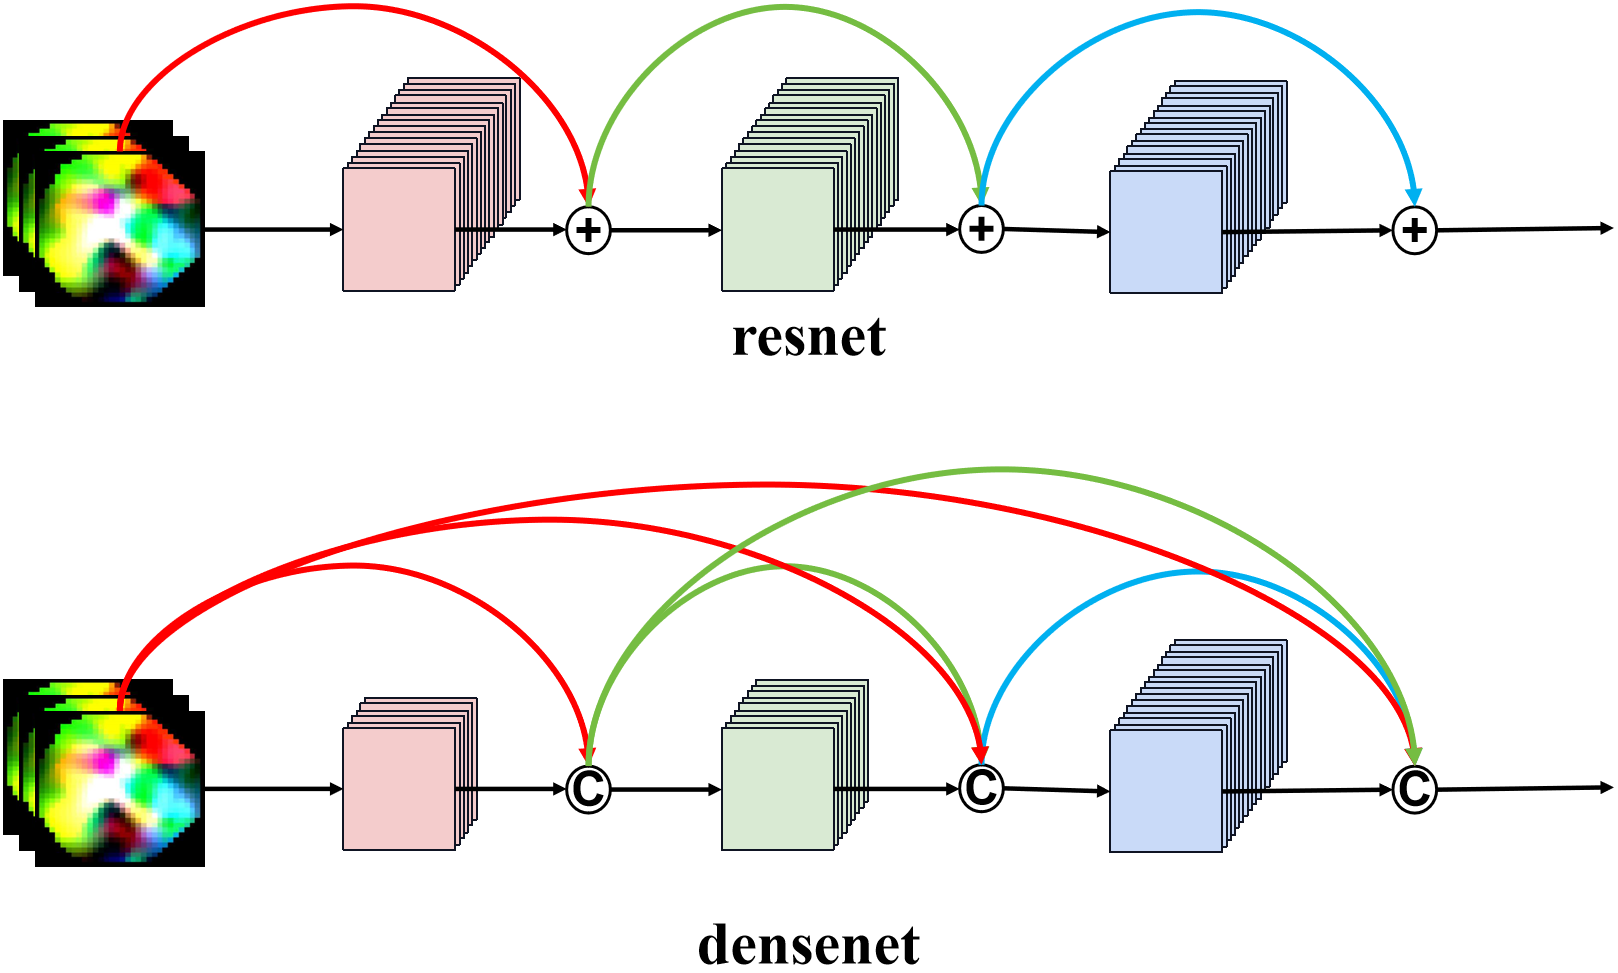

In [ ]:
import torch
from torch import nn
import sys
sys.path.append('..')
from tools import tool_pytorch_017 as ty

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        # 一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))
        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

def transition_block(input_channels, num_channels):
    '''由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。 而过渡层可以用来控制模型复杂度。
        它通过1x1卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。'''
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        # 1x1卷积层，减小通道数
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2))
    
blk = transition_block(23, 10)
blk(Y).shape

# DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层。
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# 接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。 与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。 
# 这里我们设成4，从而与ResNet-18保持一致。 稠密块里的卷积层通道数（即增长率）设为32，所以每个稠密块将增加128个通道。
# 在每个模块之间，ResNet通过步幅为2的残差块减小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

# 与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。      
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10))

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = ty.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(ty.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


#@save
def train_AlexNet(net, train_iter, test_iter, num_epochs, lr, device):
    """训练AlexNet模型"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = ty.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = ty.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = ty.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], ty.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = ty.load_data_fashion_mnist(batch_size, resize=96)
train_AlexNet(net, train_iter, test_iter, num_epochs, lr, ty.try_gpu())